# Предсказание временных рядов

## Введение. Постановка целей и задач.

**Цель:** Планируется расширение сельхозугодий на n-ной территории за счет выделения судсидий из госбюджета. Одной из важных задач в данном направлении, является определение устойчивого теплого климата и подходящие температурные режимы для засева территории различными культурами. На основе исторических данных, взятых с декабря 2014 по ноябрь 2018 года, необходимо проанализировать устоявшийся климат, выделить самые теплые и самые холодные периоды, дать прогноз на ближайшие 5 лет помесячно по основным важнейшим метрикам, определяющим подходящие культуры для засева.

**Задачи:** Анализ данных и визуальное представление результатов и важнейших на наш взгляд факторов. Прогнозирование факторов (выбрать 1) на 5 лет вперед.

### Импорт Датафрейма, библиотек, написание функций.

In [7]:
pip install pmdarima

In [8]:
pip install fbprophet

In [9]:
pip install statsmodels

In [10]:
## Здесь импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.tsa
from matplotlib import pyplot as plt
import math
# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                             # для поиска ARIMA моделей
# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [11]:
## Здесь импортируем данные.
df = pd.read_csv('MtWashingtonDailyTemps.csv')
print(len(df)) # количество строк в датасете
print(df.head())

1461
        DATE  MinTemp  MaxTemp  AvgTemp  AvgWindSpeed  Sunrise  Sunset
0  12/1/2014        3       36       20          65.1      700    1608
1  12/2/2014        1       22       12          34.7      702    1607
2  12/3/2014        8       32       20          53.0      703    1607
3  12/4/2014       -5        9        2          60.2      704    1607
4  12/5/2014        6       17       12          30.5      705    1607


In [12]:
## Обязательно проверьте, что все выгрузилось корректно.
print(df.head(1461))

            DATE  MinTemp  MaxTemp  AvgTemp  AvgWindSpeed  Sunrise  Sunset
0      12/1/2014        3       36       20          65.1      700    1608
1      12/2/2014        1       22       12          34.7      702    1607
2      12/3/2014        8       32       20          53.0      703    1607
3      12/4/2014       -5        9        2          60.2      704    1607
4      12/5/2014        6       17       12          30.5      705    1607
...          ...      ...      ...      ...           ...      ...     ...
1456  11/26/2018       14       25       20          26.6      655    1610
1457  11/27/2018       12       18       15          43.0      656    1609
1458  11/28/2018       11       16       14          29.4      657    1609
1459  11/29/2018       10       23       17          40.5      658    1608
1460  11/30/2018       18       25       22           4.3      659    1608

[1461 rows x 7 columns]


### Знакомство с данными.

In [13]:
# Смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          1461 non-null   object 
 1   MinTemp       1461 non-null   int64  
 2   MaxTemp       1461 non-null   int64  
 3   AvgTemp       1461 non-null   int64  
 4   AvgWindSpeed  1461 non-null   float64
 5   Sunrise       1461 non-null   int64  
 6   Sunset        1461 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 80.0+ KB


Итак, в нашем датафрейме представлена такая информация, как

**DATE** - Дата. ВАЖНО: У нас есть данные на каждый день.

**MinTemp** - Мин t. Нулевых значений нет, представлено целым числом

**MaxTemp** - Макс t. Нулевых значений нет, представлено целым числом

**AvgTemp** - Средняя t. Нулевых значений нет, представлено целым числом

**AvgWindSpeed** - Средняя скорость ветра. Нулевых значений нет, представлено числом с плавающей точкой.

**Sunrise** - Время восхода, представлено криво, как часы+минуты 

**Sunset** - Время заката, представлено криво, как часы+минуты 

## Предобработка данных

### Фильтрация данных

Несмотря на то, что мы имеем показатели на каждый день, для анализа нам вполне достаточно отобразить такие метрики, как средняя/минимальная/максимальная t в месяц, для метрик типа скорость ветра достаточно отобразить только среднее значение в месяц.

Давайте выведем необходимые метрики с группировкой по месяцам.

In [14]:
## Добавим новый столбец, по которому и будем выполнять агрегацию
df['DATE'] = pd.to_datetime(df['DATE'])
df['Years_Months'] = df['DATE'].values.astype('datetime64[M]')
df

,DATE,MinTemp,MaxTemp,AvgTemp,AvgWindSpeed,Sunrise,Sunset,Years_Months
0,2014-12-01,3,36,20,65.1,700,1608,2014-12-01
1,2014-12-02,1,22,12,34.7,702,1607,2014-12-01
2,2014-12-03,8,32,20,53.0,703,1607,2014-12-01
3,2014-12-04,-5,9,2,60.2,704,1607,2014-12-01
4,2014-12-05,6,17,12,30.5,705,1607,2014-12-01
...,...,...,...,...,...,...,...,...
1456,2018-11-26,14,25,20,26.6,655,1610,2018-11-01
1457,2018-11-27,12,18,15,43.0,656,1609,2018-11-01
1458,2018-11-28,11,16,14,29.4,657,1609,2018-11-01
1459,2018-11-29,10,23,17,40.5,658,1608,2018-11-01


In [15]:
df = df.groupby(by=['Years_Months'],as_index=False)[['MinTemp','MaxTemp','AvgTemp','AvgWindSpeed']].agg(['min','max','mean']).reset_index()
df.head()

Years_Months MinTemp                MaxTemp                AvgTemp      \
                   min max       mean     min max       mean     min max   
0   2014-12-01     -14  33   9.419355      -8  44  23.967742     -11  39   
1   2015-01-01     -34  12  -8.870968     -11  39  11.225806     -20  25   
2   2015-02-01     -35  13 -14.535714     -15  30   4.357143     -21  22   
3   2015-03-01     -23  17  -2.516129      -9  29  14.806452     -13  23   
4   2015-04-01      -3  29  15.500000       7  44  28.800000       2  35   

             AvgWindSpeed                   
        mean          min   max       mean  
0  16.870968         15.8  71.4  40.003226  
1   1.096774         15.3  86.5  49.090323  
2  -5.250000         12.8  91.2  42.446429  
3   6.258065         15.6  84.7  46.074194  
4  22.400000         13.5  77.4  40.933333

In [16]:
df.columns

MultiIndex([('Years_Months',     ''),
            (     'MinTemp',  'min'),
            (     'MinTemp',  'max'),
            (     'MinTemp', 'mean'),
            (     'MaxTemp',  'min'),
            (     'MaxTemp',  'max'),
            (     'MaxTemp', 'mean'),
            (     'AvgTemp',  'min'),
            (     'AvgTemp',  'max'),
            (     'AvgTemp', 'mean'),
            ('AvgWindSpeed',  'min'),
            ('AvgWindSpeed',  'max'),
            ('AvgWindSpeed', 'mean')],
           )

Работа с двойными индексами может стать обременительной. Чтобы не создавать лишних сложностей, можно заменить имена столбцов следующим образом:

In [17]:
stats = ['min','max','mean']
df.columns = ['Years_Months']+['MinTemp_{}'.format(stat) for stat in stats]+['MaxTemp_{}'.format(stat) for stat in stats]+['AvgTemp_{}'.format(stat) for stat in stats]+['AvgWindSpeed_{}'.format(stat) for stat in stats]
df.head()

,Years_Months,MinTemp_min,MinTemp_max,MinTemp_mean,MaxTemp_min,MaxTemp_max,MaxTemp_mean,AvgTemp_min,AvgTemp_max,AvgTemp_mean,AvgWindSpeed_min,AvgWindSpeed_max,AvgWindSpeed_mean
0,2014-12-01,-14,33,9.419355,-8,44,23.967742,-11,39,16.870968,15.8,71.4,40.003226
1,2015-01-01,-34,12,-8.870968,-11,39,11.225806,-20,25,1.096774,15.3,86.5,49.090323
2,2015-02-01,-35,13,-14.535714,-15,30,4.357143,-21,22,-5.250000,12.8,91.2,42.446429
3,2015-03-01,-23,17,-2.516129,-9,29,14.806452,-13,23,6.258065,15.6,84.7,46.074194
4,2015-04-01,-3,29,15.500000,7,44,28.800000,2,35,22.400000,13.5,77.4,40.933333


In [18]:
df = df[['Years_Months','MinTemp_min','MaxTemp_max','AvgTemp_mean','AvgWindSpeed_mean']]
df.head()

,Years_Months,MinTemp_min,MaxTemp_max,AvgTemp_mean,AvgWindSpeed_mean
0,2014-12-01,-14,44,16.870968,40.003226
1,2015-01-01,-34,39,1.096774,49.090323
2,2015-02-01,-35,30,-5.250000,42.446429
3,2015-03-01,-23,29,6.258065,46.074194
4,2015-04-01,-3,44,22.400000,40.933333


### Обработка пропусков

В наших данных пропусков нет.
Но, если бы они были, перед группировкой по месяцам, нам пришлось бы заполнить пропуски как неким средним значением между двумя известными до и после.
Это изрядно бы усложнило предобработку данных.

### Вывод по этапу.


In [19]:
df.head()

,Years_Months,MinTemp_min,MaxTemp_max,AvgTemp_mean,AvgWindSpeed_mean
0,2014-12-01,-14,44,16.870968,40.003226
1,2015-01-01,-34,39,1.096774,49.090323
2,2015-02-01,-35,30,-5.250000,42.446429
3,2015-03-01,-23,29,6.258065,46.074194
4,2015-04-01,-3,44,22.400000,40.933333


## EDA или разведочный анализ данных.

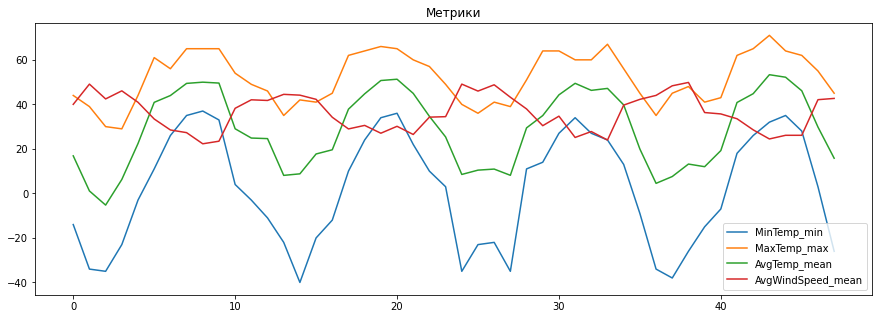

In [20]:
fig, ax = plt.subplots(1, 1)
ax = df['MinTemp_min'].plot(figsize=(15,5))
ax = df['MaxTemp_max'].plot(figsize=(15,5))
ax = df['AvgTemp_mean'].plot(figsize=(15,5))
ax = df['AvgWindSpeed_mean'].plot(figsize=(15,5))
ax.set(title='Метрики')
plt.legend()
plt.show()

Давайте посмотрим на наши данные. Наши данные идеально размещаются на одном графике, на котором мы видим, явно выраженные периоды с самой низкой/высокой температурой. Также, мы видим, что средняя температура является своего рода медианным показателем. Спрогнозировав именно среднюю температуру в месяц, в дальнейшем мы сможем применить коэффициенты для получения более актуальных значений.
Колебания ветра в данном случае, нам лишь сообщают о том, что зимой ветра сильнее.
Важный момент, стоит обратить внимание на начало 2017 года, там вырисовывается фигура "перевернутый бэтман", причем единственный раз. Скорее всего, это выброс, зима 2017 г была холоднее и продолжительнее других. На этом важно акцентировать внимание, т.к. при прогнозе, обучаясь на более ранних данных, здесь статически возможны отклонения. Сглаживать его мы не будем, возьмем как есть.

In [21]:
## Убираем все лишнее
df = df[['Years_Months','AvgTemp_mean']]
## Делаем дату индексом
df = df.set_index('Years_Months')
df.head()

,AvgTemp_mean
Years_Months,
2014-12-01,16.870968
2015-01-01,1.096774
2015-02-01,-5.250000
2015-03-01,6.258065
2015-04-01,22.400000


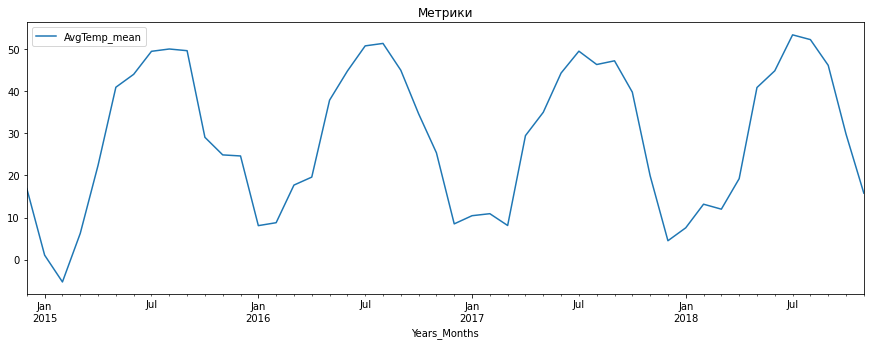

In [22]:
# Еще раз взглянем на график
fig, ax = plt.subplots(1, 1)
ax = df['AvgTemp_mean'].plot(figsize=(15,5))
ax.set(title='Метрики')
plt.legend()
plt.show()

In [23]:
# Проведем расчет основных статистических метрик
df.describe()

,AvgTemp_mean
count,48.000000
mean,28.875890
std,17.081151
min,-5.250000
25%,12.883929
50%,29.232796
75%,44.833333
max,53.322581


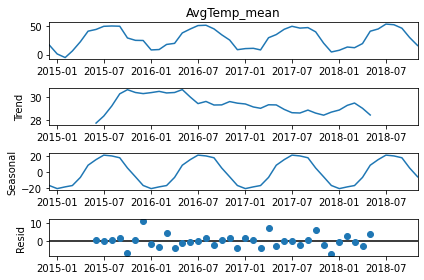

In [24]:
r = seasonal_decompose(df['AvgTemp_mean'], model='additive')
r.plot();

Есть незначительный тренд на снижение средней температуры, подтверждаем явно выраженную сезонность

## Построение моделей, анализ результатов.

1.0 SARIMAX

In [25]:
# Запустим pmdarima.auto_arima чтобы получить набор параметров
auto_arima(df['AvgTemp_mean'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -117.164
Date:                  Thu, 24 Mar 2022   AIC                            236.327
Time:                          09:42:11   BIC                            237.911
Sample:                               0   HQIC                           236.880
                                   - 48                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        39.3003      8.940      4.396      0.000      21.777      56.823
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.77   Prob(JB):                         0.83
Heteroskedasticity (H):               0.68   Skew:                            -0.23
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# Разделим выборки
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [27]:
model = SARIMAX(train['AvgTemp_mean'],seasonal_order=(0, 1, 0, 12))
results = model.fit() #обучаем модель на обучающей выборке данных
results.summary() #получаем результаты

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       AvgTemp_mean   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 -79.529
Date:                            Thu, 24 Mar 2022   AIC                            163.058
Time:                                    09:42:11   BIC                            165.414
Sample:                                12-01-2014   HQIC                           163.683
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0567      0.201      0.281      0.778      -0.338       0.451
sigma2        44.2297     12.938      3.419      0.001      18.871      69.588
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.95   Prob(JB):                         0.81
Heteroskedasticity (H):               0.49   Skew:                            -0.30
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#Получаем предсказанные значения и пытаемся оценить качество прогноза
start=len(train) #первая точка в тестовом множестве
end=len(train)+len(test)-1 #последняя точка в тестовом множеств
#предсказываем значения,передав модели results точку начала и окончания
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMAX(1, 0, 0)x(0, 1, 0, 12)')

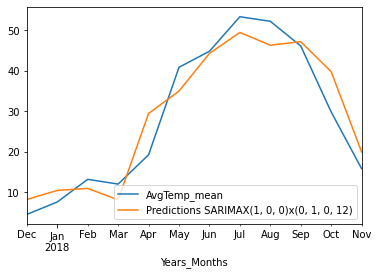

In [29]:
#Сравниваем результаты
test['AvgTemp_mean'].plot(legend=True)
predictions.plot(legend=True)

[Text(0, 0.5, 't'), Text(0.5, 0, '')]

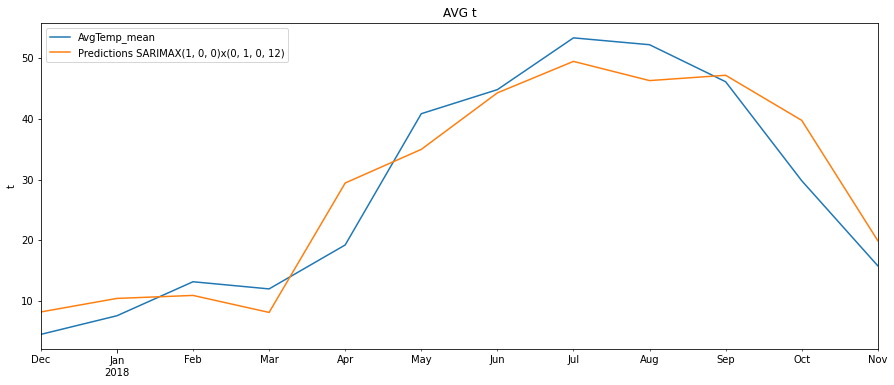

In [30]:
#Строим графики

##добавляем
title = 'AVG t' #название графика
ylabel = 't' #название оси Y
xlabel = '' #название оси Х


ax = test['AvgTemp_mean'].plot(legend=True, figsize=(15,6),title=title) #добавлем заголовок
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [31]:
#Оцениваем модель методом MSE (Среднеквадратическая ошибка Mean Square Error) и RMSE (Среднеквадратическое отклонение Root Mean Square Error)

mse_value = mean_squared_error(test['AvgTemp_mean'], predictions)
rmse_value = rmse(test['AvgTemp_mean'], predictions)
mape_error = np.mean(np.abs(predictions - test['AvgTemp_mean'])/test['AvgTemp_mean'])*100

print(f'SARIMAX(1,0,0)(0, 1, 0, 12) MSE Error: {mse_value:11.10}') #квадрат от единиц измерения 11 - кол-во символов (с точкой), 10 - после точки (сколько оставнется, но макс 10) 
print(f'SARIMAX(1,0,0)(0, 1, 0, 12) RMSE Error: {rmse_value:11.10}') #единицы те же, что и само измерение
print(f'SARIMAX(1,0,0)(0, 1, 0, 12) MAPE Error: {mape_error:11.10}')

SARIMA(1,0,0)(0, 1, 0, 12) MSE Error: 28.94887983
SARIMA(1,0,0)(0, 1, 0, 12) RMSE Error: 5.380416325
SARIMA(1,0,0)(0, 1, 0, 12) MAPE Error: 26.47583303


MSE (чем меньше, тем лучше и меньше грубых ошибок) = 28,9
MAPE (чем меньше, тем лучше и меньше грубых ошибок) = 26,5
Модель приемлимого качества, но могла быть и лучше

In [32]:
#Не знаем данных будущего, поэтому обучаем модель на всем датасете (обучение без учителя)

model = SARIMAX(df['AvgTemp_mean'],order=(1, 0, 0),seasonal_order=(0, 1, 0, 12))
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       AvgTemp_mean   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -117.122
Date:                            Thu, 24 Mar 2022   AIC                            238.243
Time:                                    09:42:11   BIC                            241.410
Sample:                                12-01-2014   HQIC                           239.349
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0489      0.162      0.301      0.763      -0.269       0.367
sigma2        39.2036      9.215      4.254      0.000      21.143      57.265
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.99   Prob(JB):                         0.80
Heteroskedasticity (H):               0.72   Skew:                            -0.26
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Прогнозируем на год вперед
fcast = results.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(1, 0, 0)x(0, 1, 0, 12) Forecast') 

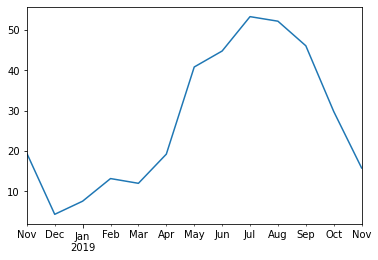

In [34]:
#Посмотрим на forecast для всего датасета на год вперед
fcast.plot()

[Text(0, 0.5, 't'), Text(0.5, 0, '')]

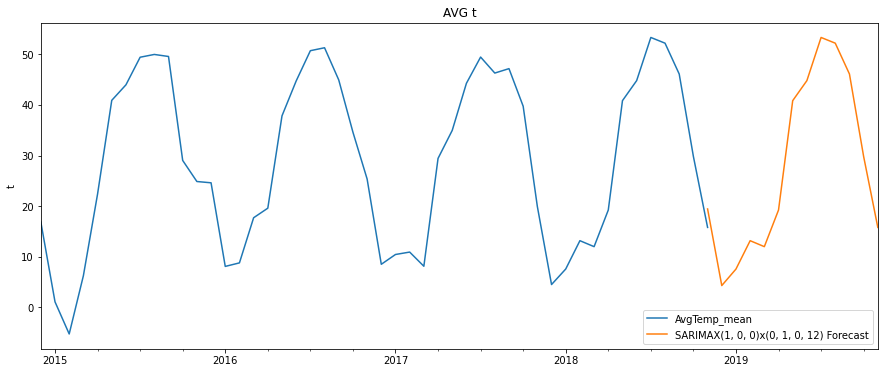

In [35]:
#Строим графики

##добавляем
title = 'AVG t' #название графика
ylabel = 't' #название оси Y
xlabel = '' #название оси Х


ax_SARIMAX = df['AvgTemp_mean'].plot(legend=True, figsize=(15,6),title=title) 
fcast.plot(legend=True)
ax_SARIMAX.autoscale(axis='x',tight=True)
ax_SARIMAX.set(xlabel=xlabel, ylabel=ylabel)

Выводы по модели SARIMAX:
На самом деле мы видим, что прогноз полностью повторяет последний год

2.0 PROPHET

In [36]:
from fbprophet import Prophet

In [37]:
model = Prophet()
model

In [38]:
train_0 = train.reset_index() #Индекс сбросим, чтобы работать только с колонками.
test_0 = test.reset_index() #Индекс сбросим, чтобы работать только с колонками.

In [39]:
# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_0.columns = ['ds', 'y'] # переименовали столбцы
test_0.columns = ['ds', 'y'] # переименовали столбцы

df_prophet = df
df_prophet = df.reset_index()
df_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [40]:
train_0.head() #посмотрим преобразование после переименования колонок

,ds,y
0,2014-12-01,16.870968
1,2015-01-01,1.096774
2,2015-02-01,-5.250000
3,2015-03-01,6.258065
4,2015-04-01,22.400000


In [41]:
model.fit(train_0) # подогнали модель под наши данные

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Посмотрим на качество получившейся модели. Для этого нам необходимо задать горизонт прогнозирования (в нашем случае это год) и создать дата-фрейм с датами из «будущего», для которого модель потом будет строить прогноз.

make_future_dataframe() — метод профета, который создает дата-фрейм с временным периодом будущего. В аргумент ему мы передаем periods и задаем количество элементов, на которые хотим получить прогноз.

Так как наши данные имеют месячную гранулярность, прогноз мы также получим по месяцам от последней даты на количество месяцев, указанное в скобках.

In [42]:
future = model.make_future_dataframe(periods=12, freq='MS') # говорим профету сделать дата-фрейм на 12 месяцев
future.tail(12) # выводим 12 строк с конца

,ds
36,2017-12-01
37,2018-01-01
38,2018-02-01
39,2018-03-01
40,2018-04-01
41,2018-05-01
42,2018-06-01
43,2018-07-01
44,2018-08-01
45,2018-09-01


Теперь можем построить прогноз методом .predict.

Применим его к нашей модели и запишем в отдельную переменную.

доверительный интервал по умолчанию 95%, это популярный стандарт, который вполне нас устраивает

In [43]:
forecast = model.predict(future)
forecast.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-12-01,27.540743,13.732167,21.265231,27.540743,27.540743,-10.074513,-10.074513,-10.074513,-10.074513,-10.074513,-10.074513,0.0,0.0,0.0,17.466230
1,2015-01-01,27.620948,1.557568,9.164265,27.620948,27.620948,-22.274749,-22.274749,-22.274749,-22.274749,-22.274749,-22.274749,0.0,0.0,0.0,5.346199
2,2015-02-01,27.701152,-0.411458,7.280075,27.701152,27.701152,-24.125441,-24.125441,-24.125441,-24.125441,-24.125441,-24.125441,0.0,0.0,0.0,3.575711
3,2015-03-01,27.773596,1.917215,9.527082,27.773596,27.773596,-22.101035,-22.101035,-22.101035,-22.101035,-22.101035,-22.101035,0.0,0.0,0.0,5.672560
4,2015-04-01,27.853800,20.773668,28.451983,27.853800,27.853800,-3.083352,-3.083352,-3.083352,-3.083352,-3.083352,-3.083352,0.0,0.0,0.0,24.770448


Основные поля в прогнозе следующие:

ds — дата прогноза

yhat — спрогнозированное значение

yhat_lower — нижняя граница доверительного интервала для прогноза

yhat_upper — верхняя граница доверительного интервала для прогноза

In [44]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() # оставим только нужные

,ds,yhat,yhat_lower,yhat_upper
43,2018-07-01,51.291494,47.368821,55.089577
44,2018-08-01,50.604367,46.495806,54.351926
45,2018-09-01,49.621049,45.782529,53.697106
46,2018-10-01,34.239321,30.278136,38.007808
47,2018-11-01,24.926813,20.915849,28.417465


Также с помощью метода .plot() прогноз можно построить на графике и посмотреть визуально его адекватность.

Черные точки — наши данные.

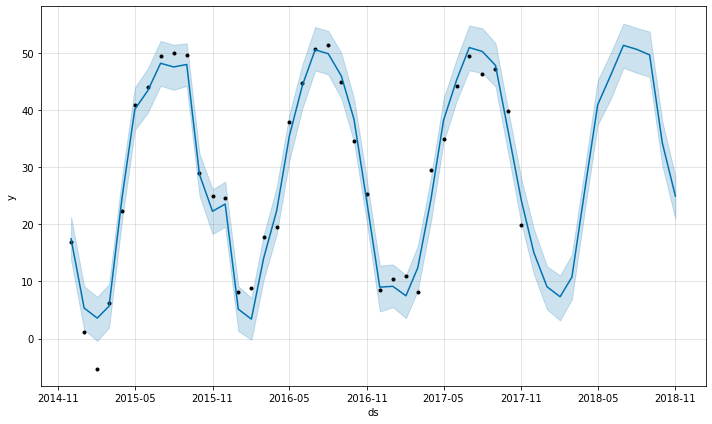

In [45]:
model.plot(forecast);

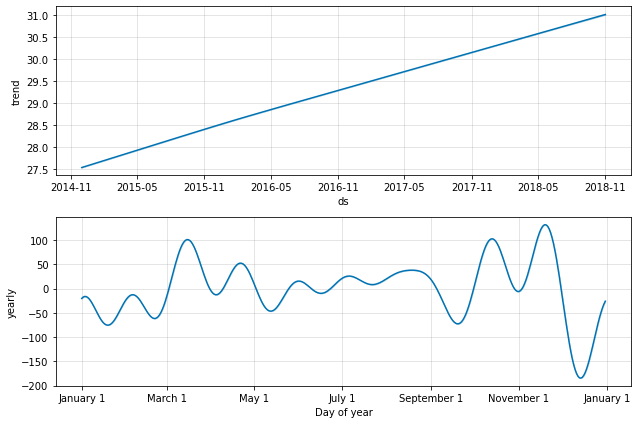

In [46]:
model.plot_components(forecast);

In [47]:
#оцениваем качество модели методом MSE, RMSE, MAPE

mse_error = mean_squared_error(test_0['y'], forecast['yhat'].tail(12))
rmse_error = rmse(test_0['y'], forecast['yhat'].tail(12))
mape_error = np.mean(np.abs(forecast['yhat'] - test_0['y'])/test_0['y'])*100

print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MSE Error: 26.74626529
Prophet RMSE Error: 5.171679156
Prophet MAPE Error: 45.22276204


MSE, RMSE примерно на том же уровне, что и по модели SARIMAX, а вот ошибка MAPE значительно выше

In [48]:
# делаем прогноз на будущее - 1 год вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='additive')
fut_model_prophet.fit(df_prophet)

# говорим профету сделать дата-фрейм на 1 год вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12, freq='MS')
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


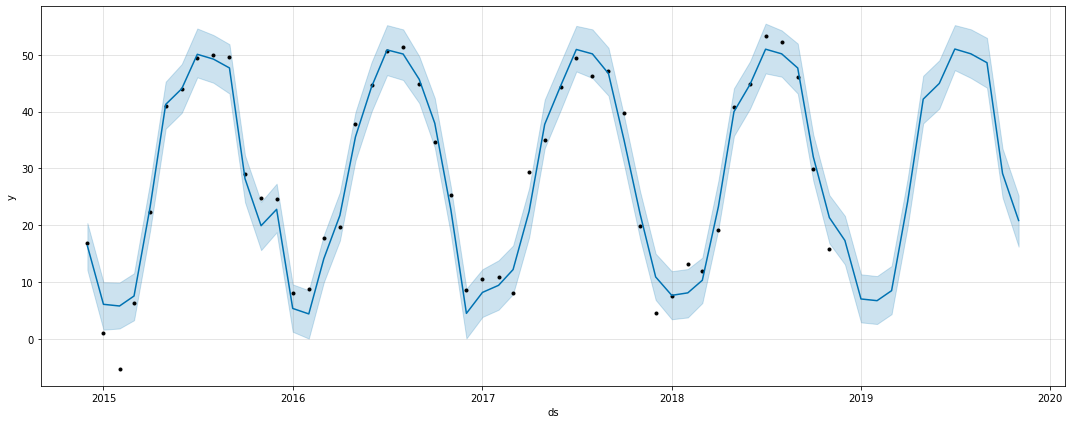

In [49]:
# Строим график
fut_model_prophet.plot(fut_fcast_prophet, figsize=(15,6));

In [50]:
from matplotlib import pyplot as plt
import math

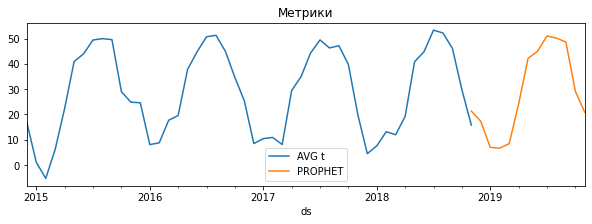

In [51]:
# устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

# И построим график на будущее
ax_PROPHET = df['AvgTemp_mean'].plot(legend=True, figsize=(10,3),title='Метрики') 
fut_fcast_prophet['yhat'].tail(13).plot(legend=True)
ax_PROPHET.autoscale(axis='x',tight=True)
ax_PROPHET.legend(["AVG t", "PROPHET"]);


Выводы по модели PROPHET: Достойно, но по метрикам немного хуже из-за увеличения MAPE показателя

3.0 Экспоненцальное сглаживание

In [52]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['AvgTemp_mean'], seasonal_periods=12, trend = 'add')# годовая сезонность, тк единица времени = месяц

# обучаем модель на обучающей выборке данных
model_exps.fit ()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [53]:
# посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 16.802478441264864,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.08749258834661888,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9999999850988388,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.0,
 'use_boxcox': False}

In [54]:
# определяем точку начала для прогноза
test.index[0]

Timestamp('2017-12-01 00:00:00')

In [55]:
# определяем точку окончания для прогноза
test.index[-1]

Timestamp('2018-11-01 00:00:00')

In [56]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [57]:
prediction_exps

array([20.02082622, 20.10831881, 20.19581139, 20.28330398, 20.37079657,
       20.45828916, 20.54578175, 20.63327434, 20.72076692, 20.80825951,
       20.8957521 , 20.98324469])

In [58]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2017-12-01 00:00:00", periods=12, freq="M")
prediction_exps.columns = ['prediction_exps']

In [59]:
#проверим
prediction_exps.head(15)

,prediction_exps
2017-12-31,20.020826
2018-01-31,20.108319
2018-02-28,20.195811
2018-03-31,20.283304
2018-04-30,20.370797
2018-05-31,20.458289
2018-06-30,20.545782
2018-07-31,20.633274
2018-08-31,20.720767
2018-09-30,20.808260


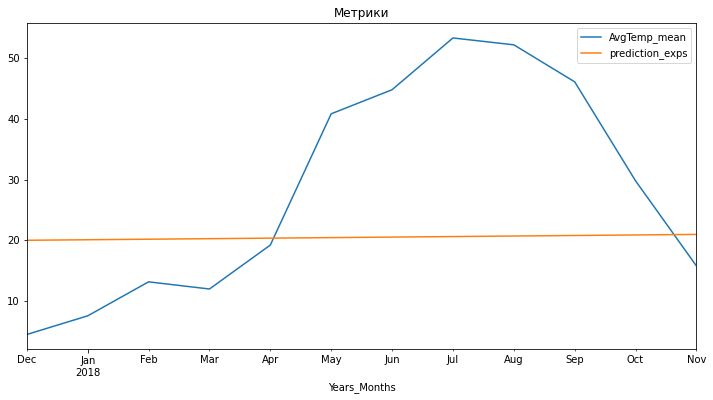

In [60]:
#сравниваем прогноз и тестовую выборку

title = 'Метрики' #название графика

ax_ES = test['AvgTemp_mean'].plot(legend=True, figsize=(12,6),title=title)
prediction_exps['prediction_exps'].plot(legend=True)
ax_ES.autoscale(axis='x',tight=True)

Прогноз не удался, как при разборе ДЗ по прогнозированию, давайте выведем метрики ошибок и посмотрим что там, скорее всего значение ошибок будет запредельное

In [61]:
mse_error = mean_squared_error(test['AvgTemp_mean'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['AvgTemp_mean'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['AvgTemp_mean'])/test['AvgTemp_mean'])*100

print(f'Exponential smoothing MSE Error: {mse_error:11.10}')
print(f'Exponential smoothing RMSE Error: {rmse_error:11.10}')
print(f'Exponential smoothing MAPE Error: {mape_error:11.10}')

Exponential smoothing MSE Error: 360.4317448
Exponential smoothing RMSE Error: 18.98504003
Exponential smoothing MAPE Error:         nan


Фактически, получив такие данные и визуально оценив прогноз можно смело заканчивать работу с данным методом, т.к. никакого стоящего прогноза не выйдет.

## Выводы

[Text(0, 0.5, 't'), Text(0.5, 0, '')]

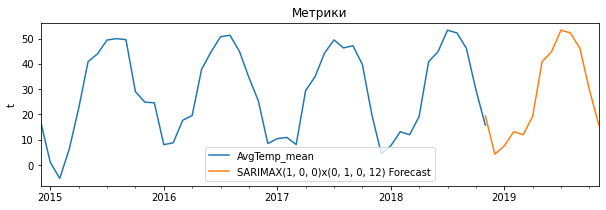

In [69]:
ax_SARIMAX = df['AvgTemp_mean'].plot(legend=True, figsize=(10,3),title=title) 
fcast.plot(legend=True)
ax_SARIMAX.autoscale(axis='x',tight=True)
ax_SARIMAX.set(xlabel=xlabel, ylabel=ylabel)

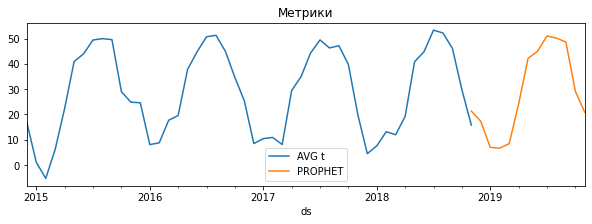

In [65]:
ax_PROPHET = df['AvgTemp_mean'].plot(legend=True, figsize=(10,3),title='Метрики') 
fut_fcast_prophet['yhat'].tail(13).plot(legend=True)
ax_PROPHET.autoscale(axis='x',tight=True)
ax_PROPHET.legend(["AVG t", "PROPHET"]);

В результате анализа и прогнозирования на горизонт в один год вперед, мы имеем следующие результаты:
  Модель SARIMAX:
  MSE Error: 28.94887983 /
  RMSE Error: 5.380416325 /
  MAPE Error: 26.47583303
  PROPHET:
  MSE Error: 26.74626529 /
  RMSE Error: 5.171679156 /
  MAPE Error: 45.22276204 
  Метод Экспоненцального сглаживания не показал достойного результата.

  Визуально, оба прогноза получились приемлимыми, аномалий нет в cпрогнозируемых значениях, но лучше, по метрике MAPE все же SARIMAX